In [1]:
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [3]:
# run_query('''
# create or replace table max_dev.workspace.user_title_hours_watched_test2
# (
# request_date	VARCHAR, 
# viewable_id VARCHAR,
# hours_viewed	float
# );
# ''')

In [4]:
# run_query('''
# create or replace table max_dev.workspace.user_title_hours_watched_subs 
# (
# start_date VARCHAR,
# end_date VARCHAR,
# DAYS_ON_HBO_MAX int,
# subs 	bigint
# );
# ''')

In [6]:
title_info = run_query('''
with offerings as (select DISTINCT
            case when season_number is not null then concat(title_name, ' S', season_number, ('E'), EPISODE_NUMBER_IN_SEASON)
            else title_name end as title_episode_name
    , title_name
    , rad.VIEWABLE_ID
    , concat(coalesce(rad.series_id, rad.viewable_id)) as title_id
    , rad.SERIES_ID
    , rad.SEASON_NUMBER
    , EPISODE_NUMBER_IN_SEASON
    , content_category
    , PRIMARY_GENRE_DESC
    , program_type
    , aod.air_date
    , ASSET_RUN_TIME
    , offering_start_date
    , offering_end_date
     FROM "MAX_PROD"."CATALOG"."ASSET_OFFERING_DIM" aod
LEFT JOIN "MAX_PROD"."CATALOG"."REPORTING_ASSET_DIM" rad ON aod.VIEWABLE_ID = rad.VIEWABLE_ID
where territory='HBO MAX DOMESTIC'
    and channel = 'HBO MAX SUBSCRIPTION'
    and OFFERING_TYPE = 'FEATURE')

, airtable as (
    select DISTINCT title_id 
    , MIN(PILLAR_GENRE) as PILLAR_GENRE -- multiple PILLAR GENRE assignments for a single VIEWABLE_ID, taking at random.
    from max_prod.catalog.airtable_content_strategy group by title_id)

, pay1 as (
    SELECT DISTINCT viewable_id, is_pay_1
    FROM max_prod.staging.tentpole_titles_stg stg
    WHERE stg.territory = 'HBO MAX DOMESTIC'
    and stg.theatrical_release_date is not null
    and stg.is_pay_1 =1
)

, budget as (
    SELECT DISTINCT map.viewable_id, bdg.AMOUNT as budget
    FROM "MAX_PROD"."CKG".IMDB_BOXOFFICE_TITLE_BUDGET bdg
    JOIN max_prod.ckg.ed_wm_wb_imdb_mapping map --vid to imdb_id
    ON map.imdb_id=bdg.title_id
)

,offerings_by_date as (
select
     TITLE_NAME, title_episode_name
    , offerings.VIEWABLE_ID
    , offerings.title_id, offerings.SEASON_NUMBER
    , CONTENT_CATEGORY, program_type, air_date
    , am.home_territory_observed_medal as medal
    , CAST(FLOOR(COALESCE( (ASSET_RUN_TIME)/60/60 ,0)*(1000000*1.0)) AS DECIMAL(38,0))
          / CAST((1000000*1.0) AS DOUBLE PRECISION) as ASSET_RUN_TIME_HOURS -- to prevent floating point errors
    , case when to_date(offerings.offering_start_date) < '2020-05-27' THEN to_date('2020-05-27')
           ELSE to_date(offerings.offering_start_date)
           end as offering_start_date
    , to_date(offerings.offering_end_date) as offering_end_date
    , PRIMARY_GENRE_DESC
    , aos.PILLAR_GENRE as PILLAR_GENRE
    , EPISODE_NUMBER_IN_SEASON
    , CASE WHEN pay1.is_pay_1 IS NOT NULL THEN 1 ELSE 0 END AS is_pay_1
    , CASE WHEN pop.THEATRICAL_RELEASE_DATE IS NOT NULL THEN 1 ELSE 0 END AS is_popcorn
    , MAX(budget) AS budget 
FROM offerings
LEFT JOIN airtable aos ON (offerings.title_id = aos.title_id)
LEFT JOIN max_prod.content_analytics.asset_medals am 
        on offerings.title_id = am.title_id
        and coalesce(offerings.season_number,0) = coalesce(am.season,0)
LEFT JOIN pay1
        on pay1.viewable_id = offerings.viewable_id
LEFT JOIN max_prod.catalog.popcorn_titles pop 
        on pop.viewable_id = offerings.viewable_id
LEFT JOIN budget
        on budget.viewable_id = offerings.viewable_id
WHERE 1=1
-- offerings.OFFERING_START_DATE > '2020-05-01'
-- and CURRENT_DATE() between (OFFERING_START_DATE) and (OFFERING_END_DATE)
GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
)

SELECT * FROM offerings_by_date
''')

In [7]:
### DE-DUPTE THE TITLES

title_test_dedup = title_info.groupby(['viewable_id'])['offering_start_date'].min().reset_index()
title_info = title_info.merge(title_test_dedup, on = ['viewable_id', 'offering_start_date'])

title_test_dedup = title_info.groupby(['viewable_id'])['offering_end_date'].max().reset_index()
title_info = title_info.merge(title_test_dedup, on = ['viewable_id', 'offering_end_date'])

title_info['medal'] = title_info['medal'].fillna('None')
title_test_dedup = title_info.groupby(['viewable_id'])['medal'].max().reset_index()
title_info = title_info.merge(title_test_dedup, on = ['viewable_id', 'medal'])


title_info = title_info.drop_duplicates()
title_info['season_number'] = title_info['season_number'].fillna(0)

In [8]:
title_info.count()

title_name                  43360
title_episode_name          43360
viewable_id                 43360
title_id                    43360
season_number               43360
content_category            42993
program_type                42844
air_date                    43094
medal                       43360
asset_run_time_hours        43360
offering_start_date         43360
offering_end_date           43360
primary_genre_desc          43360
pillar_genre                37238
episode_number_in_season    36143
is_pay_1                    43360
is_popcorn                  43360
budget                       3702
dtype: int64

In [9]:
### SANITY CHECK
title_test = title_info.groupby(['viewable_id']).count()
title_test[title_test['title_name'] == 2]

,title_name,title_episode_name,title_id,season_number,content_category,program_type,air_date,medal,asset_run_time_hours,offering_start_date,offering_end_date,primary_genre_desc,pillar_genre,episode_number_in_season,is_pay_1,is_popcorn,budget
viewable_id,,,,,,,,,,,,,,,,,


In [10]:
title_series_info = title_info.groupby(['title_id', 'season_number'])['offering_start_date'].min().reset_index()

title_series_test = title_info.groupby(['title_id', 'season_number'])['asset_run_time_hours'].sum().reset_index()
title_series_info = title_series_info.merge(title_series_test, on = ['title_id', 'season_number'])

title_series_test = title_info.groupby(['title_id', 'season_number'])[['content_category', 'program_type', 'air_date', 'medal', 'episode_number_in_season',
                                                                       'pillar_genre', 'is_pay_1', 'is_popcorn', 'budget']].first().reset_index()
title_series_info = title_series_info.merge(title_series_test, on = ['title_id', 'season_number'])

In [11]:
# title_info = title_info[['title_name', 'viewable_id', 'title_id', 'season_number']].merge(
#                         title_series_info,  on = ['title_id', 'season_number'])

In [12]:
## WRITE OR READ FROM S3 ####
import boto3
import io

s3 = boto3.resource('s3')
output_bucket = "hbo-outbound-datascience-content-dev"
input_bucket = "hbo-ingest-datascience-content-dev"
bucket = s3.Bucket(input_bucket)

def write_to_sf(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)
    
def write_to_input(df, file_name):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    filename = 'title_hours_viewed_retention/{}.csv'.format(file_name)
    client = boto3.client('s3')
    client.put_object(Bucket=input_bucket, Key=filename, Body=content)
    
def read_from_s3(filename, input_bucket = input_bucket):
    for obj in bucket.objects.filter(Prefix='title_hours_viewed_retention/'+filename): #churn_metric_0811
            key = obj.key 
            body = obj.get()['Body']
            print('Reading {0} features'.format(key))
            df = pd.read_csv(body, na_values = [r'\\\\N'])
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [13]:
write_to_sf(title_series_info, 'title_series_info')
# table max_dev.workspace.user_title_hours_watched_title_series_info 
# table max_dev.workspace.user_title_hours_watched_episodic_info 

In [14]:
# run_query('''
# create or replace table max_dev.workspace.user_title_hours_watched_title_series_info 
# (
# title_id	VARCHAR,
# season_number	int,
# offering_start_date	VARCHAR,
# asset_run_time_hours	float,
# content_category	VARCHAR,
# program_type	VARCHAR,
# air_date	VARCHAR,
# medal	VARCHAR,
# episode_number_in_season int,
# pillar_genre VARCHAR,
# is_pay_1    int,            
# is_popcorn    int,     
# budget    int
# );

# ''')

In [15]:
# run_query('''
# copy into max_dev.workspace.user_title_hours_watched_title_series_info
#     from(
#         select
#               $1, $2, $3, $4, $5, $6, $7, $8, $9, $10, $11, $12,$13
#         from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/title_hours_viewed_retention/title_series_info.csv
#         )
#     file_format = (type = csv null_if=('') skip_header = 1  FIELD_OPTIONALLY_ENCLOSED_BY='"')
#     on_error = 'CONTINUE';

# ''')

In [16]:
# run_query('''
# create or replace table max_dev.workspace.user_title_hours_watched_episodic_info 
# (
# title_name	VARCHAR,
# title_episode_name	VARCHAR, 
# viewable_id	VARCHAR,
# title_id	VARCHAR,
# season_number	int,
# content_category	VARCHAR,
# program_type	VARCHAR,
# air_date	VARCHAR, 
# medal	VARCHAR,
# asset_run_time_hours	float,
# offering_start_date	VARCHAR,
# offering_end_date	VARCHAR,
# primary_genre_desc	VARCHAR,
# pillar_genre	VARCHAR,
# episode_number_in_season int,
# is_pay_1	int,            
# is_popcorn	int,     
# budget	int
# );

# ''')

In [17]:
# write_to_sf(title_info, 'title_episodic_info')

In [18]:
# run_query('''
# copy into max_dev.workspace.user_title_hours_watched_episodic_info
#     from(
#         select
#               $1, $2, $3, $4, $5, $6, $7, $8, $9, $10, $11, $12,$13, $14, $15, $16,$17, $18
#         from @HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV/title_hours_viewed_retention/title_episodic_info.csv
#         )
#     file_format = (type = csv null_if=('') skip_header = 1  FIELD_OPTIONALLY_ENCLOSED_BY='"')
#     on_error = 'CONTINUE' FORCE = True; 

# ''')

In [19]:
title_hours_viewed = run_query('''
WITH viewing_hours AS (
SELECT e.title_name, t.title_id, t.season_number, h.request_date, t.offering_start_date, t.asset_run_time_hours
,DATEDIFF('DAY', t.offering_start_date::DATE, h.request_date::DATE) as days_on_hbo_max
,SUM(h.hours_viewed) AS daily_hours_viewed
,SUM(daily_hours_viewed) OVER (PARTITION BY t.title_id, t.season_number order by DAYS_ON_HBO_MAX) as cumulative_hours_viewed
FROM MAX_DEV.WORKSPACE.user_title_hours_watched_test2 h
JOIN (SELECT DISTINCT viewable_id, title_id, season_number, title_name FROM
    max_dev.workspace.user_title_hours_watched_episodic_info)  e
    on h.viewable_id = e.viewable_id
JOIN max_dev.workspace.user_title_hours_watched_title_series_info    t
    on e.title_id = t.title_id
    and e.season_number = t.season_number
WHERE 1=1
AND DATEDIFF('DAY', t.offering_start_date::DATE, h.request_date::DATE) >= 0
GROUP BY 1,2,3,4,5,6,7
ORDER BY t.TITLE_ID, t.SEASON_NUMBER, DAYS_ON_HBO_MAX
)
select v.*,subs
,cumulative_hours_viewed/subs as average_hours_viewed
from viewing_hours v
JOIN max_dev.workspace.user_title_hours_watched_subs s
    on v.offering_start_date = s.start_date
    and v.days_on_hbo_max = s.days_on_hbo_max
''')

In [20]:
content_cost = read_from_s3('content_cost.csv')

Reading title_hours_viewed_retention/content_cost.csv features


In [21]:
content_cost.columns = [i.lower() for i in content_cost.columns]

In [22]:
content_cost.head()

,title_id,season_number,title_name,gross_cost_1,adj_gross_cost_1,amortized_cost,efc,content_cost
0,GXdu2SAeB7puAuwEAADZ8,0,Final Destination 3,nan,nan,"300,000.00",nan,"300,000.00"
1,GVU3T5wTXyoNJjhsJAXsL,0,Coma,nan,nan,"80,000.00",nan,"80,000.00"
2,GYK0ljAlihwmgpgEAAAAM,0,Set Up,nan,nan,"150,000.00",nan,"150,000.00"
3,GYnQshQAwncM-owEAAAAD,0,Unfinished Song,nan,nan,"173,864.00",nan,"173,864.00"
4,GYrGCXQAmMQCdrAEAAAHD,0,Infinitely Polar Bear,nan,nan,"95,498.00",nan,"95,498.00"


### Catigorical feature 

In [23]:
content_category_onehot = pd.get_dummies(title_series_info['content_category'], prefix='content_category')
title_series_info=pd.concat([title_series_info, content_category_onehot], axis = 1)

In [24]:
program_type_onehot = pd.get_dummies(title_series_info['program_type'], prefix='program_type')
title_series_info=pd.concat([title_series_info, program_type_onehot], axis = 1)

In [25]:
genre_onehot = pd.get_dummies(title_series_info['pillar_genre'], prefix='genre')
title_series_info=pd.concat([title_series_info, genre_onehot], axis = 1)

In [26]:
title_series_info.medal.unique()

array(['None', 'Gold', 'Silver', 'Bronze', 'Platinum'], dtype=object)

In [27]:
# Medal Data
medal_dict = {'Silver':2, 'Bronze':3, 'Gold':1 , 'Platinum':0, 'None':np.NaN}
title_series_info['medal_number'] = title_series_info['medal'].replace(medal_dict)

In [28]:
title_series_info['is_new_content'] = 0

In [29]:
### Air date and Release date < 1 year
title_series_info.loc[(pd.to_datetime(title_series_info['offering_start_date'])-
                      pd.to_datetime(title_series_info['air_date']))/np.timedelta64(1, 'Y') <= 1,
                      'is_new_content']=1

In [30]:
title_series_info['age_of_content'] = (pd.to_datetime(title_series_info['offering_start_date'])-
                      pd.to_datetime(title_series_info['air_date']))/np.timedelta64(1, 'Y')

In [31]:
data = title_hours_viewed[['title_name', 'title_id', 'season_number', 'days_on_hbo_max', 'cumulative_hours_viewed', 'average_hours_viewed']].merge(
       title_series_info, on = ['title_id', 'season_number'])
data = data[data['days_on_hbo_max'] == 60]
data['hvr'] = data['cumulative_hours_viewed']/data['asset_run_time_hours']
data['ahvr'] = data['average_hours_viewed']/data['asset_run_time_hours']

In [32]:
data = data.merge(content_cost[['title_id', 'season_number', 'content_cost']], on = ['title_id', 'season_number'], how = 'left')

In [33]:
data[['asset_run_time_hours', 'content_category', 'program_type', 'air_date', 'episode_number_in_season', 'content_cost',
                   'medal', 'pillar_genre', 'is_pay_1', 'is_popcorn', 'budget']]\
.isnull().sum()/len(data)

asset_run_time_hours       0.00
content_category           0.00
program_type               0.00
air_date                   0.00
episode_number_in_season   0.70
content_cost               0.46
medal                      0.00
pillar_genre               0.04
is_pay_1                   0.00
is_popcorn                 0.00
budget                     0.61
dtype: float64

In [34]:
# data.to_csv('validation_data.csv')
# data = pd.read_csv('validation_data.csv')
# data = data.drop(['Unnamed: 0'], axis = 1)

In [35]:
# write_to_sf(data, 'validation_data')

In [36]:
data = data[pd.to_datetime(data['offering_start_date']) >= pd.to_datetime('2021-01-01')]

In [37]:
len(data)# 7416

3694

In [38]:
data.head()

,title_name,title_id,season_number,days_on_hbo_max,cumulative_hours_viewed,average_hours_viewed,offering_start_date,asset_run_time_hours,content_category,program_type,air_date,medal,episode_number_in_season,pillar_genre,is_pay_1,is_popcorn,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Adult Animation,genre_Classics,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Kids/Family,genre_Music,genre_Other,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,genre_Unscripted,medal_number,is_new_content,age_of_content,hvr,ahvr,content_cost
5,Hitman,GV-BGQgMBlMLDwwEAAAAy,0,60,"147,364.96",0.01,2021-10-01,1.54,movies,acquired,2007-11-21,None,nan,Action/Adventure,0,0,"24,000,000.00",0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,0,13.86,"95,399.02",0.01,"285,000.00"
7,Meet Dave,GV-BH1AH5lhgVsQEAAABJ,0,60,"114,823.42",0.01,2022-09-01,1.51,movies,acquired,2008-07-11,None,nan,Comedy,0,0,"60,000,000.00",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,nan,0,14.14,"76,266.51",0.01,"230,000.00"
8,The Sand Pebbles,GV-BK7wNv6MLCwgEAAABw,0,60,"6,272.51",0.00,2021-03-01,2.98,movies,acquired,1966-01-01,None,nan,Classics,0,0,"12,000,000.00",0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,nan,0,55.16,"2,102.13",0.00,"230,000.00"
9,Matchstick Men,GV-BKigrJWcJMwwEAAABi,0,60,"177,819.93",0.01,2021-06-01,1.89,movies,acquired,2003-09-12,None,nan,Drama,0,0,"62,000,000.00",0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,nan,0,17.72,"93,850.14",0.01,"175,000.00"
10,Miracle on 34th Street,GV-BKvAt0FsJMwwEAAABv,0,60,"2,531.15",0.00,2021-07-01,1.61,movies,acquired,1947-01-01,None,nan,Kids/Family,0,0,nan,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,nan,0,74.50,"1,575.68",0.00,"92,000.00"


In [39]:
data.medal.unique()

array(['None', 'Gold', 'Silver', 'Bronze', 'Platinum'], dtype=object)

In [40]:
data.loc[data['medal'] == 'None', 'medal'] = 'Bronze'

In [41]:
data.medal.unique()

array(['Bronze', 'Gold', 'Silver', 'Platinum'], dtype=object)

In [42]:
data_cannibal = data[['title_id','title_name', 'season_number', 'offering_start_date','medal', 'medal_number', 'pillar_genre']].copy()
data_aird = data[['title_id','title_name', 'season_number', 'offering_start_date', 'content_category', 'program_type', 'air_date', 'medal', 'pillar_genre', 'is_pay_1', 'is_popcorn']].copy()

In [43]:
data_cannibal['date_start'] = data_cannibal['offering_start_date'] - pd.DateOffset(days=31)
data_cannibal['date_end'] = data_cannibal['offering_start_date'] + pd.DateOffset(days=31)

In [44]:
data_aird.columns = [i+'_2' for i in data_aird.columns]

In [47]:
# !pip install sqldf 

In [48]:
import sqldf 

In [49]:
data_cannibal = sqldf.run(
        """
            select * 
            from data_cannibal
            join data_aird
            on data_cannibal.offering_start_date <= data_aird.offering_start_date_2
            and data_cannibal.date_end >= data_aird.offering_start_date_2
        """
    )

In [50]:
data_cannibal = data_cannibal.drop(['index'], axis = 1)

In [51]:
data_cannibal['is_movie_2'] = 1
data_cannibal.loc[data_cannibal['content_category_2']!= 'movies', 'is_movie_2'] = 0

data_cannibal['is_series_2'] = 1
data_cannibal.loc[data_cannibal['content_category_2']!= 'series', 'is_series_2'] = 0

data_cannibal['is_acquired_2'] = 1
data_cannibal.loc[data_cannibal['program_type_2']!= 'acquired', 'is_acquired_2'] = 0

data_cannibal['is_original_2'] = 1
data_cannibal.loc[data_cannibal['program_type_2']!= 'original', 'is_original_2'] = 0

data_cannibal['is_medal_Platinum'] = 1
data_cannibal.loc[data_cannibal['medal_2']!= 'Platinum', 'is_medal_Platinum'] = 0

data_cannibal['is_medal_same'] = 1
data_cannibal.loc[data_cannibal['medal_2']!= data_cannibal['medal'], 'is_medal_same'] = 0

data_cannibal['is_genre_same'] = 1
data_cannibal.loc[data_cannibal['pillar_genre_2']!= data_cannibal['pillar_genre'], 'is_genre_same'] = 0

data_cannibal['is_current'] = 1
data_cannibal.loc[(pd.to_datetime(data_cannibal['offering_start_date_2']) - pd.to_datetime(data_cannibal['air_date_2'])).dt.days > 365, 
                  'is_current'] = 0

In [52]:
data_final = data_cannibal.groupby(['title_id', 'season_number'])\
[['is_pay_1_2', 'is_popcorn_2', 'is_movie_2', 'is_series_2', 'is_acquired_2', 'is_original_2', 'is_medal_Platinum', 'is_medal_same', 'is_genre_same', 'is_current']\
].sum().reset_index()

In [53]:
data_cannibal.head()

,title_id,title_name,season_number,offering_start_date,medal,medal_number,pillar_genre,date_start,date_end,title_id_2,title_name_2,season_number_2,offering_start_date_2,content_category_2,program_type_2,air_date_2,medal_2,pillar_genre_2,is_pay_1_2,is_popcorn_2,is_movie_2,is_series_2,is_acquired_2,is_original_2,is_medal_Platinum,is_medal_same,is_genre_same,is_current
0,GV-BGQgMBlMLDwwEAAAAy,Hitman,0,2021-10-01,Bronze,nan,Action/Adventure,2021-08-31 00:00:00,2021-11-01 00:00:00,GV-BGQgMBlMLDwwEAAAAy,Hitman,0,2021-10-01,movies,acquired,2007-11-21,Bronze,Action/Adventure,0,0,1,0,1,0,0,1,1,0
1,GV-BGQgMBlMLDwwEAAAAy,Hitman,0,2021-10-01,Bronze,nan,Action/Adventure,2021-08-31 00:00:00,2021-11-01 00:00:00,GV-LJSA5eFZqOiQEAAAAq,"Lucia, Lucia",0,2021-11-01,movies,acquired,2003-07-25,Bronze,Comedy,0,0,1,0,1,0,0,1,0,0
2,GV-BGQgMBlMLDwwEAAAAy,Hitman,0,2021-10-01,Bronze,nan,Action/Adventure,2021-08-31 00:00:00,2021-11-01 00:00:00,GV1nmIwfwNZSMwwEAAABt,Say Anything...,0,2021-10-01,movies,acquired,1989-04-14,Bronze,Comedy,0,0,1,0,1,0,0,1,0,0
3,GV-BGQgMBlMLDwwEAAAAy,Hitman,0,2021-10-01,Bronze,nan,Action/Adventure,2021-08-31 00:00:00,2021-11-01 00:00:00,GV40E6Qsrx7fDNQEAAAA-,The Conspirator,0,2021-11-01,movies,acquired,2010-01-01,Bronze,Drama,0,0,1,0,1,0,0,1,0,0
4,GV-BGQgMBlMLDwwEAAAAy,Hitman,0,2021-10-01,Bronze,nan,Action/Adventure,2021-08-31 00:00:00,2021-11-01 00:00:00,GV4ei9w3FJpubawEAAAAJ,Child 44,0,2021-10-01,movies,acquired,2015-04-17,Bronze,Drama,0,0,1,0,1,0,0,1,0,0


In [59]:
data.head()

,title_name,title_id,season_number,days_on_hbo_max,cumulative_hours_viewed,average_hours_viewed,offering_start_date,asset_run_time_hours,content_category,program_type,air_date,medal,episode_number_in_season,pillar_genre,is_pay_1,is_popcorn,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Adult Animation,genre_Classics,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Kids/Family,genre_Music,genre_Other,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,genre_Unscripted,medal_number,is_new_content,age_of_content,hvr,ahvr,content_cost,pay_1_count,popcorn_count,movie_count,series_count,acquired_count,original_count,medal_Platinum_count,medal_same_count,genre_same_count,current_content_count
0,Hitman,GV-BGQgMBlMLDwwEAAAAy,0,60,"147,364.96",0.01,2021-10-01,1.54,movies,acquired,2007-11-21,Bronze,nan,Action/Adventure,0,0,"24,000,000.00",0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,0,13.86,"95,399.02",0.01,"285,000.00",6,2,273,82,341,23,1,358,45,46
1,Meet Dave,GV-BH1AH5lhgVsQEAAABJ,0,60,"114,823.42",0.01,2022-09-01,1.51,movies,acquired,2008-07-11,Bronze,nan,Comedy,0,0,"60,000,000.00",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,nan,0,14.14,"76,266.51",0.01,"230,000.00",4,0,171,75,242,6,1,245,46,42
2,The Sand Pebbles,GV-BK7wNv6MLCwgEAAABw,0,60,"6,272.51",0.00,2021-03-01,2.98,movies,acquired,1966-01-01,Bronze,nan,Classics,0,0,"12,000,000.00",0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,nan,0,55.16,"2,102.13",0.00,"230,000.00",1,1,221,29,237,16,2,249,11,32
3,Matchstick Men,GV-BKigrJWcJMwwEAAABi,0,60,"177,819.93",0.01,2021-06-01,1.89,movies,acquired,2003-09-12,Bronze,nan,Drama,0,0,"62,000,000.00",0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,nan,0,17.72,"93,850.14",0.01,"175,000.00",5,2,196,51,234,13,2,243,55,20
4,Miracle on 34th Street,GV-BKvAt0FsJMwwEAAABv,0,60,"2,531.15",0.00,2021-07-01,1.61,movies,acquired,1947-01-01,Bronze,nan,Kids/Family,0,0,nan,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,nan,0,74.50,"1,575.68",0.00,"92,000.00",7,1,172,21,179,16,0,185,18,39


In [54]:
data_final.columns = ['title_id', 'season_number','pay_1_count', 'popcorn_count', 'movie_count', 'series_count', 'acquired_count', 'original_count', 
                         'medal_Platinum_count', 'medal_same_count', 'genre_same_count', 'current_content_count']

In [55]:
len(data_cannibal)

799036

In [56]:
data = data.merge(data_final, on = ['title_id', 'season_number'])

In [57]:
len(data)

3694

In [58]:
write_to_input(data, 'Cannibalization Analysis.csv')
write_to_input(data_cannibal, 'cannibalization_analysis_detailed_view.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


# CORRELATION

## 1. HVR

In [104]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [105]:
META_COLS = ['title_name', 'title_id', 'season_number', 'offering_start_date', 'asset_run_time_hours']
FEATURE_COLS = ['is_pay_1', 'is_popcorn', 'is_new_content', 'medal_number', 'age_of_content', 'episode_number_in_season', 'content_cost',
               'budget', 'content_category_livesports', 'content_category_movies',
               'content_category_series', 'content_category_special',
               'program_type_acquired', 'program_type_original',
               'genre_Action/Adventure ', 'genre_Adult Animation', 'genre_Classics',
               'genre_Comedy', 'genre_Documentary', 'genre_Drama', 'genre_Horror ',
               'genre_Kids/Family', 'genre_Music', 'genre_Other', 'genre_Romance',
               'genre_Sci-Fi', 'genre_Suspense/Thriller', 'genre_Unscripted',
                'pay_1_count', 'popcorn_count', 'movie_count', 'series_count', 'acquired_count', 'original_count', 
                'medal_Platinum_count', 'medal_same_count', 'genre_same_count', 'current_content_count'
               ]

In [106]:
TARGET_COL = ['hvr'] #cumulative_hours_viewed

In [107]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,hvr
dummy_value,-1.00
medal_number,-0.72
medal_same_count,-0.25
age_of_content,-0.14
episode_number_in_season,-0.08
acquired_count,-0.08
movie_count,-0.07
program_type_acquired,-0.07
genre_Classics,-0.06
genre_same_count,-0.06


<AxesSubplot:>

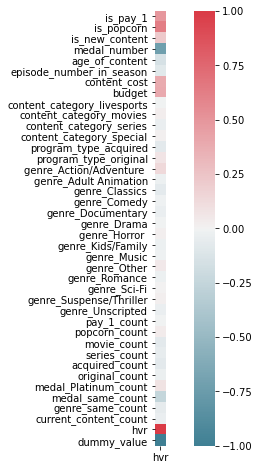

In [108]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## 2. Log HVR

In [111]:
data['log_hvr'] = np.log2(data['hvr'])

In [112]:
TARGET_COL = ['log_hvr'] #cumulative_hours_viewed

In [113]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,log_hvr
dummy_value,-1.00
medal_number,-0.64
genre_Classics,-0.25
age_of_content,-0.22
genre_Documentary,-0.13
content_category_series,-0.09
episode_number_in_season,-0.09
program_type_original,-0.08
genre_Unscripted,-0.08
content_category_special,-0.07


<AxesSubplot:>

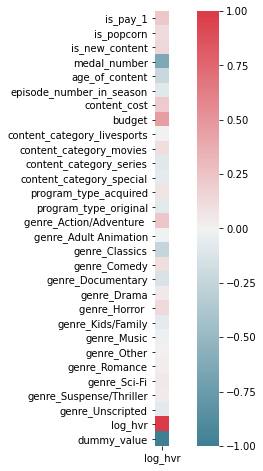

In [114]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## 2. HV per Subsciber

In [115]:
TARGET_COL = ['ahvr'] #cumulative_hours_viewed

In [116]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,ahvr
dummy_value,-1.00
medal_number,-0.57
age_of_content,-0.11
genre_Classics,-0.07
genre_Documentary,-0.04
program_type_acquired,-0.04
genre_Unscripted,-0.03
episode_number_in_season,-0.02
genre_Music,-0.01
genre_Suspense/Thriller,-0.01


<AxesSubplot:>

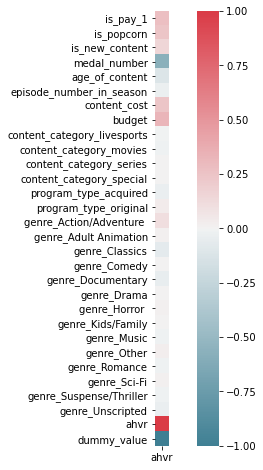

In [117]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

## Content Goups

In [71]:
imdb_mapping = run_query(''' 
SELECT DISTINCT COALESCE(viewable_series_id, viewable_id) as title_id
, COALESCE(imdb_series_id, imdb_id) as imdb_id
FROM max_prod.ckg.ed_wm_wb_imdb_mapping map
WHERE title_id is not null''')

In [72]:
content_groups = pd.read_csv('8_clusters_data.csv')

In [73]:
content_groups = pd.merge(content_groups[['new_imdb_id', 'Dominant_Topic']],
                         imdb_mapping, left_on = ['new_imdb_id'], right_on = ['imdb_id'])

In [74]:
data = data.merge(content_groups[['title_id', 'Dominant_Topic']], on = ['title_id'], how = 'left')

In [75]:
data[['Dominant_Topic', 'content_cost','medal', 'pillar_genre', 'is_pay_1', 'is_popcorn', 'budget']]\
.isnull().sum()/len(data)

Dominant_Topic   0.29
content_cost     0.47
medal            0.00
pillar_genre     0.05
is_pay_1         0.00
is_popcorn       0.00
budget           0.62
dtype: float64

In [76]:
# data['Dominant_Topic'] = data['Dominant_Topic'].astype(str)
topic_onehot = pd.get_dummies(data['Dominant_Topic'], prefix='Dominant_Topic')
data=pd.concat([data, topic_onehot], axis = 1)

In [77]:
data.columns

Index(['title_name', 'title_id', 'season_number', 'days_on_hbo_max',
       'cumulative_hours_viewed', 'average_hours_viewed',
       'offering_start_date', 'asset_run_time_hours', 'content_category',
       'program_type', 'air_date', 'medal', 'episode_number_in_season',
       'pillar_genre', 'is_pay_1', 'is_popcorn', 'budget',
       'content_category_livesports', 'content_category_movies',
       'content_category_series', 'content_category_special',
       'program_type_acquired', 'program_type_original',
       'genre_Action/Adventure ', 'genre_Adult Animation', 'genre_Classics',
       'genre_Comedy', 'genre_Documentary', 'genre_Drama', 'genre_Horror ',
       'genre_Kids/Family', 'genre_Music', 'genre_Other', 'genre_Romance',
       'genre_Sci-Fi', 'genre_Suspense/Thriller', 'genre_Unscripted',
       'medal_number', 'is_new_content', 'age_of_content', 'hvr', 'ahvr',
       'content_cost', 'Dominant_Topic', 'Dominant_Topic_0.0',
       'Dominant_Topic_1.0', 'Dominant_Topic_2.0'

In [103]:
FEATURE_COLS = ['is_pay_1', 'is_popcorn', 'is_new_content', 'medal_number', 'age_of_content', 'episode_number_in_season', 'content_cost',
               'budget', 'content_category_livesports', 'content_category_movies',
               'content_category_series', 'content_category_special',
               'program_type_acquired', 'program_type_original',
               'genre_Action/Adventure ', 'genre_Adult Animation', 'genre_Classics',
               'genre_Comedy', 'genre_Documentary', 'genre_Drama', 'genre_Horror ',
               'genre_Kids/Family', 'genre_Music', 'genre_Other', 'genre_Romance',
               'genre_Sci-Fi', 'genre_Suspense/Thriller', 'genre_Unscripted',
                'Dominant_Topic', 'Dominant_Topic_0.0',
               'Dominant_Topic_1.0', 'Dominant_Topic_2.0', 'Dominant_Topic_3.0',
               'Dominant_Topic_4.0', 'Dominant_Topic_5.0', 'Dominant_Topic_6.0',
               'Dominant_Topic_7.0'
               ]

In [181]:
TARGET_COL = ['ahvr'] #cumulative_hours_viewed

In [184]:
plot_data['Dominant_Topic'] = plot_data['Dominant_Topic'].astype(float)

In [185]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,ahvr
dummy_value,-1.00
medal_number,-0.58
age_of_content,-0.11
genre_Classics,-0.07
genre_Documentary,-0.05
genre_Unscripted,-0.04
Dominant_Topic_6.0,-0.03
program_type_acquired,-0.03
episode_number_in_season,-0.03
Dominant_Topic_1.0,-0.02


<AxesSubplot:>

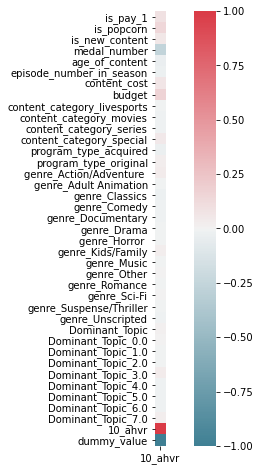

In [108]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [187]:
# Cluster 7 (Violence and Crime Dramas)

## 4. Scaler

In [109]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(data['ahvr'].to_numpy().reshape(-1, 1))
# scaler.mean_

In [38]:
data['log_ahvr'] = np.log2(data['ahvr'])

In [39]:
data.head()

,title_name,title_id,season_number,days_on_hbo_max,cumulative_hours_viewed,average_hours_viewed,offering_start_date,asset_run_time_hours,content_category,program_type,air_date,medal,episode_number_in_season,pillar_genre,is_pay_1,is_popcorn,budget,content_category_livesports,content_category_movies,content_category_series,content_category_special,program_type_acquired,program_type_original,genre_Action/Adventure,genre_Adult Animation,genre_Classics,genre_Comedy,genre_Documentary,genre_Drama,genre_Horror,genre_Kids/Family,genre_Music,genre_Other,genre_Romance,genre_Sci-Fi,genre_Suspense/Thriller,genre_Unscripted,medal_number,is_new_content,age_of_content,hvr,ahvr,content_cost,log_ahvr
0,VICE Special Report: Killing Cancer,GV-54_wnG7qbCwwEAAAAY,0,60,17.00,0.00,2020-05-27,0.64,movies,acquired,2015-01-01,None,nan,Documentary,0,0,nan,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,nan,0,5.40,26.57,0.00,nan,-15.60
1,VICE Special Report: Countdown to Zero,GV-55HghKlqbCwwEAAAAb,0,60,10.24,0.00,2020-05-27,0.81,movies,acquired,2015-01-01,None,nan,Documentary,0,0,nan,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,nan,0,5.40,12.64,0.00,nan,-16.67
2,VICE Special Report: Fixing the System,GV-55Hwvj4IaDwwEAAAAY,0,60,46.85,0.00,2020-05-27,1.11,movies,acquired,2015-01-01,None,nan,Documentary,0,0,nan,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,nan,0,5.40,42.28,0.00,nan,-14.93
3,VICE Special Report: Fighting ISIS,GV-55JASHjruwgwEAAAAU,0,60,57.65,0.00,2020-05-27,0.79,movies,original,2016-01-31,None,nan,Documentary,0,0,nan,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,nan,0,4.32,73.31,0.00,nan,-14.13
4,Heartbreakers,GV-BGJA11hsLDwwEAAAAZ,0,60,"3,799.47",0.00,2020-09-01,2.06,movies,acquired,2001-03-23,None,nan,Comedy,0,0,"35,000,000.00",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,nan,0,19.44,"1,846.39",0.00,"259,000.00",-10.69


In [40]:
TARGET_COL = ['log_ahvr'] #cumulative_hours_viewed

In [41]:
plot_data=data[FEATURE_COLS+TARGET_COL]
corr = plot_data.corr()[TARGET_COL]
mask=np.zeros_like(corr, dtype=np.bool)
corr.loc['dummy_value'] = -1
corr.sort_values(by = TARGET_COL)

,log_ahvr
dummy_value,-1.00
medal_number,-0.61
genre_Classics,-0.21
age_of_content,-0.21
episode_number_in_season,-0.09
genre_Documentary,-0.09
genre_Unscripted,-0.08
content_category_series,-0.06
genre_Kids/Family,-0.04
content_category_special,-0.04


<AxesSubplot:>

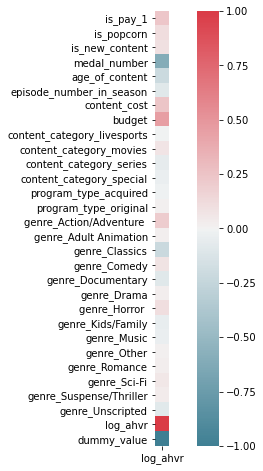

In [42]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# Distribution

In [43]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [44]:
plot_df = title_hours_viewed[['title_name', 'title_id', 'season_number', 'days_on_hbo_max', 'cumulative_hours_viewed', 'average_hours_viewed']].merge(
       title_series_info, on = ['title_id', 'season_number'])
plot_df['average hours viewed'] = plot_df['average_hours_viewed']/plot_df['asset_run_time_hours']

In [45]:
plot_df = plot_df[plot_df['days_on_hbo_max'] == 60]

In [49]:
plot_df = plot_df[(plot_df['average hours viewed'] > 0.0001)
                 &(plot_df['average hours viewed'] < 1.5)]

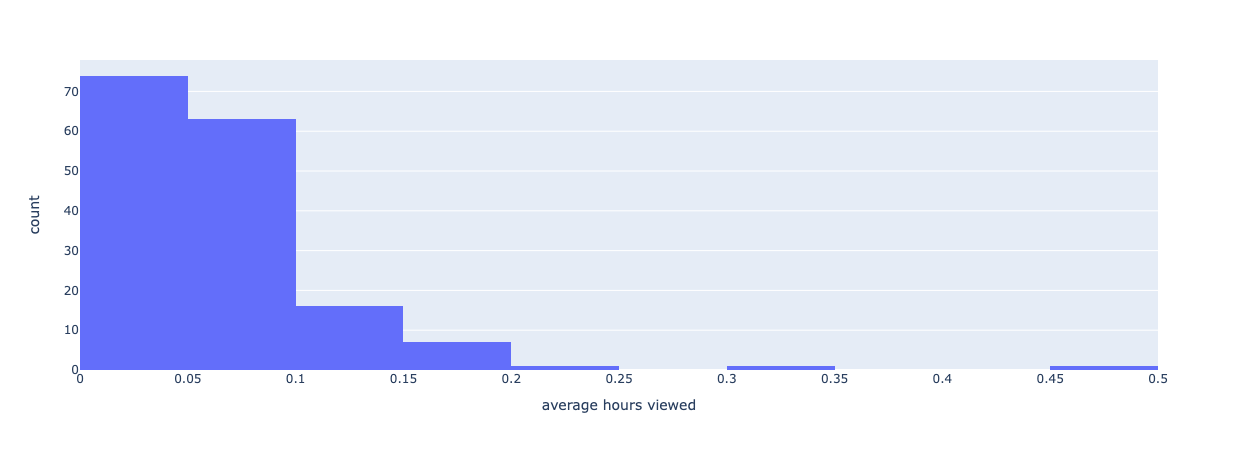

In [50]:
fig = px.histogram(plot_df, x="average hours viewed", nbins=10)
fig.show()